In [2]:
%pylab inline
import control
import pyhull
import string
import picos as pic
import cvxopt as cvx
import math
import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.integrate
import itertools
import sympy
import sympy.physics.mechanics as me
from matplotlib.patches import Ellipse

Populating the interactive namespace from numpy and matplotlib


In [8]:
def R(theta):
    R = np.array([[cos(theta), -sin(theta)], 
                  [sin(theta), cos(theta)]])
    return R

In [9]:
def omega(w_theta, w_l, w_tr):
    omega = np.array([[w_theta],[w_l],[w_tr]])
    return omega

In [609]:
def iekf(t, vt, x0, P0, dt):
    
    theta = x0[0]
    x1 = x0[1]
    x2 = x0[2]
    # left invariant error in exponential coordinate
    X = array([[cos(theta), -sin(theta), x1],
               [sin(theta), cos(theta), x2],
               [0, 0, 1]])
    
    # Initial Condition
    X_h = X
    P = P0
    Xi = array([[pi/4,0,0]]).T
    
    step = int(t/dt)
    
    v = vt[0] # velocity measured by an odometer
    w = vt[1] # velocity measured through differential odometry
    
    Out_X = []
    Out_Xi = []
    Out_Xe = []
    Out_ita = []
    
    for i in range(step):
        
        Q = diag([1,1e-4,1e-4])
        #Q = array([[1, 1e-50, 1e-50],[1e-50, 1e-4, 1e-50],[1e-50, 1e-50, 1e-4]])
        w_noise = np.random.multivariate_normal(zeros(3), sqrt(Q))
        w_theta = w_noise[0] # differential odometry error
        w_l = w_noise[1] # longitudinal odometry error
        w_tr = w_noise[2] # the transversal shift
        
        A = -array([[0, 0, 0],
                    [0, 0, -w],
                    [-v, w, 0]])
        vt = array([[0, -w, v],
                    [w, 0, 0],
                    [0, 0, 0]])
        wt = array([[0, -w_theta, w_l],
                    [w_theta, 0, w_tr],
                    [0, 0, 0]])
        
        # Reference Trajectory
        dX = X.dot((vt + wt))
        X = X + dX*dt
        Out_X.append(X)
        
        # Propagation
        dXi = A.dot(Xi) - omega(w_theta, w_l, w_tr)
        dX_h = X_h.dot(vt)
        Xi = Xi + dXi*dt
        X_h = X_h + dX_h*dt

        # Covariance Propagation
        dP = (A.dot(P)+P.dot(A.T)+Q)*dt
        P = P+dP
        
        #iekf Gain
        Vn_cov = 1e-9*eye(2)
        Vn = np.random.multivariate_normal(zeros(2), sqrt(Vn_cov))
        H = array([[0, 1, 0],
                   [0, 0, 1]])
        R = X_h[0:2,0:2]
        N = R*Vn_cov*R.T
        S = H@P@H.T + N
        Ln = P.dot(H.T).dot(inv(S)) # Gain
        
        # Measurement
        Y = X.dot(array([[0, 0, 1]]).T) + np.append(Vn,[0]).reshape(3,1)

        # update
        # updated invariant error in exp coordinate
        Xi = Xi - Ln.dot(array([[0,1,0],[0,0,1]]).dot(Xi) - R.dot(Vn.reshape(2,1))) 
        # updated invariant error
        alpha = Xi[0][0]
        u1 = Xi[1][0]
        u2 = Xi[2][0]
        if alpha < 1:
            t1 = 1 - alpha**2/6 + alpha**4/120
            t2 = alpha/2 - alpha**3/24 - alpha**5/720
        else:
            t1 = sin(alpha)/alpha
            t2 = 1-cos(alpha)/alpha
        
        Xi_x = array([[t1, -t2],
                      [t2, t1]]).dot(array([[u1],[u2]]))
        R_alpha = np.array([[cos(alpha), -sin(alpha)], 
                            [sin(alpha), cos(alpha)]])
        ita = np.vstack((np.hstack((R_alpha, Xi_x)),array([[0,0,1]])))
        # updated states
        X_h = ita.dot(X)
        
        Out_Xi.append(Xi)
        Out_Xe.append(X_h)
        Out_ita.append(ita)
           
    return Out_Xi, Out_Xe, Out_X, Out_ita

In [610]:
t = 40
vt = [10*pi/t, 2*pi/t]
x0 = [0,0,-5]
P0 = array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) # initial covariance?
dt = 0.001
Xi, Xe, X, ita = iekf(t, vt, x0, P0, dt)

In [611]:
xe_x = []
xe_y = []
xr_x = []
xr_y = []
step = int(t/dt)
for i in range(step):
    xe_x.append(Xe[i][0][2])
    xe_y.append(Xe[i][1][2])
    xr_x.append(X[i][0][2])
    xr_y.append(X[i][1][2])

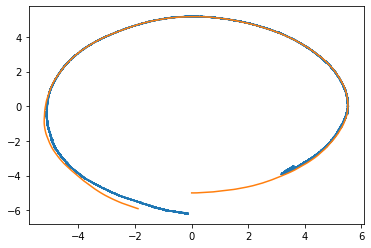

In [612]:
plot(xe_x,xe_y)
plot(xr_x,xr_y)

In [605]:
error = []
for i in range(step):
    error_x = ita[i][0][2]
    error_y = ita[i][1][2]
    error.append(sqrt(error_x**2+error_y**2))

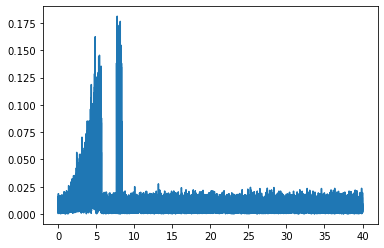

In [606]:
t_x = np.linspace(0, t, step)
plot(t_x ,error)

In [607]:
error_att = []
for i in range(step):
    error_theta = math.acos(ita[i][0][0])*180/pi
    error_att.append(error_theta)

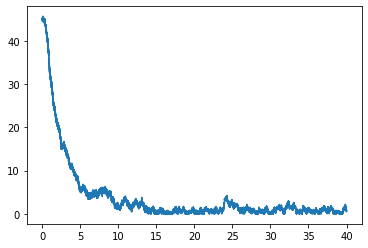

In [608]:
plot(t_x, error_att)

In [469]:
Xe

[array([[ 0.70601959, -0.70820824,  3.5628437 ],
        [ 0.70820824,  0.70601959, -3.50472881],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.70496061, -0.70926768,  3.56384084],
        [ 0.70926768,  0.70496061, -3.50218076],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.70394146, -0.71027933,  3.57595116],
        [ 0.71027933,  0.70394146, -3.48942099],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.70295683, -0.71125824,  3.57749569],
        [ 0.71125824,  0.70295683, -3.48740613],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.70203481, -0.71222348,  3.55667713],
        [ 0.71222348,  0.70203481, -3.50842042],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.70125739, -0.71325744,  3.49761022],
        [ 0.71325744,  0.70125739, -3.56721951],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.70042522, -0.71414658,  3.47143098],
        [ 0.71414658,  0.70042522, -3.5929252 ],
        

In [470]:
X

[array([[ 1.00000000e+00,  4.75058918e-03,  7.85398163e-03],
        [-4.75058918e-03,  1.00000000e+00, -5.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 1.00001305e+00,  2.00356945e-03,  1.57079633e-02],
        [-2.00356945e-03,  1.00001305e+00, -5.00003731e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 1.00001217e+00,  2.44061118e-03,  2.35620474e-02],
        [-2.44061118e-03,  1.00001217e+00, -5.00005305e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 1.00001830e+00, -6.78625008e-05,  3.14161246e-02],
        [ 6.78625008e-05,  1.00001830e+00, -5.00007222e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 1.00001769, -0.00893144,  0.03927025],
        [ 0.00893144,  1.00001769, -5.00007168],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.99984292, -0.02849984,  0.04712437],
        [ 0.02849984,  0.99984292, -5.00000154],
        [ 0. 

In [471]:
ita

[array([[ 7.02639323e-01, -7.11546191e-01, -4.05771371e-04],
        [ 7.11546191e-01,  7.02639323e-01,  2.87932921e-03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 7.03527560e-01, -7.10667976e-01, -5.76539505e-04],
        [ 7.10667976e-01,  7.03527560e-01,  4.32014285e-03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 7.02195235e-01, -7.11984447e-01, -5.54004688e-04],
        [ 7.11984447e-01,  7.02195235e-01,  4.81661853e-03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 7.02992234e-01, -7.11197524e-01, -6.28581375e-04],
        [ 7.11197524e-01,  7.02992234e-01,  5.26273819e-03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 7.08326840e-01, -7.05884614e-01, -6.12710109e-04],
        [ 7.05884614e-01,  7.08326840e-01,  5.54428463e-03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 7.21115772e-01, -6.92814581e-01, -4.45878911e-04],
        [ 6.92

In [475]:
Xi = array([[pi/4,0,0]]).T

In [477]:
np.cov(Xi)

/Users/LiYuLin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Degrees of freedom <= 0 for slice
  """Entry point for launching an IPython kernel.
/Users/LiYuLin/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/LiYuLin/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])